## Import libraries

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import random
import gym
from gym import spaces
import networkx as nx
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical
import os
import pandas as pd
pd.options.display.float_format = "{:,.2f}".format  # Display only 2 decimal points
import csv

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load Sioux Falls Network

In [3]:
net= pd.read_csv('/content/drive/MyDrive/FYP_2025/Sioux_falls_data/SiouxFalls_net.tntp', skiprows=8, sep='\t').drop(['~', ';'], axis =1)
net['edge']=net.index+1
net['length'] = net.length*5
flow=pd.read_csv('/content/drive/MyDrive/FYP_2025/Sioux_falls_data/SiouxFalls_flow.tntp',sep='\t').drop(['From ', 'To '],axis=1)
flow.rename(columns={"Volume ": "flow", "Cost ": "cost"},inplace=True)
node_coord=pd.read_csv('/content/drive/MyDrive/FYP_2025/Sioux_falls_data/SiouxFalls_node.tntp',sep='\t').drop([';'], axis=1) # Actual Sioux Falls coordinate
node_xy=pd.read_csv('/content/drive/MyDrive/FYP_2025/Sioux_falls_data/SiouxFalls_node_xy.tntp',sep='\t') # X,Y position for good visualization

In [4]:
# dataframe containing all link attributes
sioux_falls_df=pd.concat([net,flow], axis=1)
sioux_falls_df

,init_node,term_node,capacity,length,free_flow_time,b,power,speed,toll,link_type,edge,flow,cost
0,1,2,"25,900.20",30,6,0.15,4,0,0,1,1,"4,494.66",6.00
1,1,3,"23,403.47",20,4,0.15,4,0,0,1,2,"8,119.08",4.01
2,2,1,"25,900.20",30,6,0.15,4,0,0,1,3,"4,519.08",6.00
3,2,6,"4,958.18",25,5,0.15,4,0,0,1,4,"5,967.34",6.57
4,3,1,"23,403.47",20,4,0.15,4,0,0,1,5,"8,094.66",4.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,23,22,"5,000.00",20,4,0.15,4,0,0,1,72,"9,626.21",12.24
72,23,24,"5,078.51",10,2,0.15,4,0,0,1,73,"7,902.98",3.76
73,24,13,"5,091.26",20,4,0.15,4,0,0,1,74,"11,112.39",17.62
74,24,21,"4,885.36",15,3,0.15,4,0,0,1,75,"10,259.52",11.75


In [5]:
def create_graph(sioux_falls_df):
    # Create graph

    G = nx.from_pandas_edgelist(sioux_falls_df, 'init_node', 'term_node',
                                 ['capacity', 'length', 'free_flow_time', 'b', 'power', 'speed',
                                  'toll', 'link_type', 'edge', 'flow', 'cost'],
                                 create_using=nx.MultiDiGraph())

    # Coordinate positions
    pos_coord = {i: (a, b) for i, a, b in zip(node_coord.Node, node_coord.X, node_coord.Y)}
    pos_xy = {i: (a, b) for i, a, b in zip(node_xy.Node, node_xy.X, node_xy.Y)}

    # Assign positions as attributes
    for n, p in pos_coord.items():
        G.nodes[n]['pos_coord'] = p

    for n, p in pos_xy.items():
        G.nodes[n]['pos_xy'] = p

    # Define charging stations
    charging_stations = {4, 7, 20}
    for n in G.nodes:
        G.nodes[n]['charging_station'] = n in charging_stations

    return G, pos_xy, charging_stations

In [6]:
def plot_graph(G, pos):
    plt.figure(figsize=(12, 12))

    # Define node colors
    node_colors = ['red' if G.nodes[n]['charging_station'] else 'blue' for n in G.nodes]

    # Draw graph
    nx.draw_networkx(G, pos=pos, with_labels=True, node_color=node_colors,
                     arrows=True, arrowsize=20, node_size=800,
                     font_color='white', font_size=14)

    # Draw edge labels (weights)
    edge_labels = {(u, v): f"{d['length']}" for u, v, d in G.edges(data=True) if 'length' in d}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=14)

    # Legend
    plt.scatter([], [], c='red', label='Charging Station', s=200)
    plt.scatter([], [], c='blue', label='Regular Node', s=200)
    plt.legend(loc='upper right', fontsize=12)
    plt.title('Sioux Falls Network with Charging Stations', fontsize=20)

    # Save figure
    plt.savefig('sioux-falls-network.png')
    plt.show()

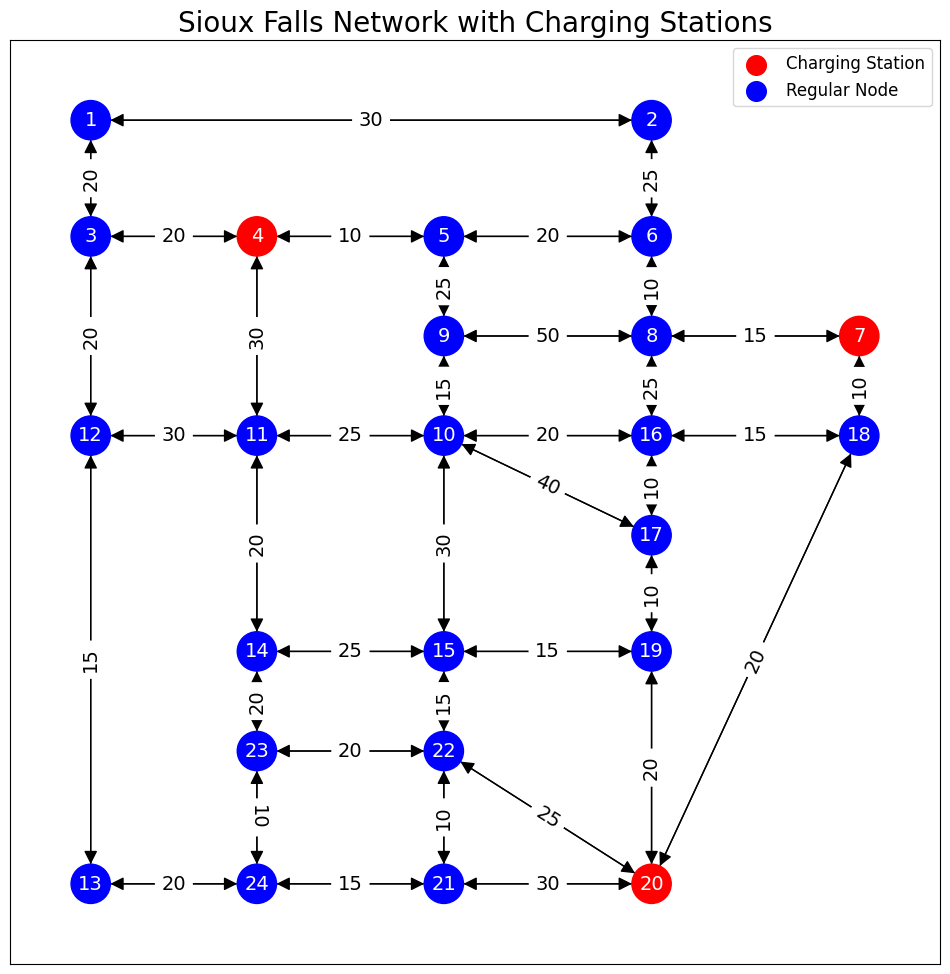

In [7]:
# Execution
G, pos,charging_stations = create_graph(sioux_falls_df)
plot_graph(G, pos)

# Assign Vehicles to Charging Station and calculate waiting time

In [ ]:
def assign_vehicle_to_cs(cs_list, beta_1, beta_2):
  with open('/content/drive/MyDrive/FYP_2025/EVData.csv', 'r') as file:
      csv_file = csv.reader(file)

      for vehicle_id, lines in enumerate(csv_file):
        start_point = int(lines[4])

        cs_keys = list(cs_list.keys())
        #print(cs_keys)

        softmax = np.zeros(len(cs_list))
        denominator = 0

        for cs in cs_keys:
          d = nx.shortest_path_length(G, source=start_point, target=cs, weight='length')
          #print(d)
          q = len(cs_list[cs])

          index = cs_keys.index(cs)
          num = np.exp(beta_1*d + beta_2*q)
          softmax[index] = num

        denominator = np.sum(softmax)  # Compute denominator for softmax

        softmax = softmax / denominator  # Normalize to get probabilities

        #print(softmax)
        charging_station = np.argmin(softmax)
        #print(charging_station)
        cs_list[cs_keys[charging_station]].append(vehicle_id)

        print("Vehicle {} starts at {} and the charging station is {}".format(vehicle_id, start_point, cs_keys[charging_station]))

  return cs_list

def calculate_waiting_time(charging_stations, rate_of_charge):
  waiting_time = {4: 0, 7: 0, 20: 0}

  with open('/content/drive/MyDrive/FYP_2025/EVData.csv', 'r') as file:
      csv_file = csv.reader(file)
      for i, lines in enumerate(csv_file):
        vehicle_id = i
        energy_required = float(lines[2])*(float(lines[4])-float(lines[3]))
        time_required = energy_required/rate_of_charge

        for cs in charging_stations:
          if vehicle_id in charging_stations[cs]:
            waiting_time[cs] += time_required
            break

  for cs in waiting_time:
    waiting_time[cs] = waiting_time[cs]/len(charging_stations[cs])*60
  return waiting_time


In [ ]:
charging_stations = {4: [], 7: [], 20: []}
beta_1 = 0.5
beta_2 = 0.5

charging_stations = assign_vehicle_to_cs(charging_stations, beta_1, beta_2)
waiting_time = calculate_waiting_time(charging_stations, 50)
print(waiting_time)

Vehicle 0 starts at 3 and the charging station is 4
Vehicle 1 starts at 5 and the charging station is 4
Vehicle 2 starts at 10 and the charging station is 7
Vehicle 3 starts at 8 and the charging station is 7
Vehicle 4 starts at 11 and the charging station is 4
Vehicle 5 starts at 19 and the charging station is 20
Vehicle 6 starts at 20 and the charging station is 20
Vehicle 7 starts at 24 and the charging station is 20
Vehicle 8 starts at 6 and the charging station is 7
Vehicle 9 starts at 1 and the charging station is 4
Vehicle 10 starts at 11 and the charging station is 4
Vehicle 11 starts at 13 and the charging station is 4
Vehicle 12 starts at 1 and the charging station is 4
Vehicle 13 starts at 5 and the charging station is 4
Vehicle 14 starts at 6 and the charging station is 7
Vehicle 15 starts at 8 and the charging station is 7
Vehicle 16 starts at 3 and the charging station is 4
Vehicle 17 starts at 4 and the charging station is 4
Vehicle 18 starts at 14 and the charging stati

# Nash Equilibrium Price

In [ ]:
from datetime import datetime
import random
import copy

In [ ]:
import numpy as np

def energy_requirement_of_customers(final_SOC, initial_SOC, battery_capacity):
    """Function to calculate the energy requirement of the nth Electric Vehicle

    Args:
        final_SOC (np.ndarray): It is a numpy array of dimension (n,1) where the nth element of the array denotes the final SOC of the nth electric vehicle
        initial_SOC (np.ndarray): It is a numpy array of dimension (n,1) where the nth element of the array denotes the initial SOC of the nth electric vehicle
        battery_capacity (np.ndarray): It is a numpy array of dimension (n,1) where the nth element of the array denotes the battery capacity of the nth electric vehicle

    Returns:
        np.ndarray: It is a numpy array where the nth element denotes the energy requirement of the nth EV
    """
    return (final_SOC-initial_SOC)*battery_capacity

def profit_of_kth_station_at_time_t(lambda_sell, lambda_purchase, energy):
    """Calculate the profit of the kth charging station

    Args:
        lambda_sell (float): A floating point value that indicates the selling of electricity to the elctric vehicle at time t
        lambda_purchase (float): A floating point value that indicates the price at which electricity is purchased from the grid at time t
        energy (np.ndarray): This is a numpy array where the nth element denotes the energy supplied to the nth EV
    Returns:
        float: The profit earned by the kth charging station
    """
    profit = lambda_sell*energy - lambda_purchase*energy
    profit = np.sum(profit)

    return profit

def calculate_energy_n(lambda_max, lambda_sell_t, S):
    """_summary_

    Args:
        lambda_max (_type_): _description_
        lambda_sell_t (_type_): _description_
        S (_type_): _description_

    Returns:
        _type_: _description_
    """
    energy_n = np.divide((lambda_max - lambda_sell_t),S)
    return energy_n

def calculate_base_sensitivity(lambda_max, lambda_b, battery_capacity):
    S_b = np.divide((lambda_max-lambda_b),battery_capacity)
    return S_b

def calculate_alpha(lambda_sell, lambda_b, lambda_max):

    val = np.divide((lambda_sell-lambda_b),(lambda_max-lambda_b))
    n = np.shape(val)[0]
    temp = np.minimum((np.ones((n,1))-val),np.ones((n,1)))
    # print(np.shape(temp))
    alpha = np.maximum(temp,np.zeros((n,1)))
    return alpha

def calculate_behavioural_response(alpha, type_="high"):
    if type_ == "high":
        return (np.exp(alpha)-1)/(np.e - 1)
    if type_ == "medium":
        return alpha
    if type_ == "low":
        return np.log(alpha*(np.e-1)+1)

def calculate_utility(S, E_n_t, lambda_max, lambda_sell):
    """_summary_

    Args:
        S (_type_): _description_
        E_n_t (_type_): _description_
        lambda_max (_type_): _description_
        lambda_sell (_type_): _description_

    Returns:
        _type_: _description_
    """
    omega = -0.5*S*np.square(E_n_t) + (lambda_max-lambda_sell)*E_n_t
    return omega

In [ ]:
def assign_vehicle_details(Cn, cs_sell_price, lambda_sell, initial_soc, final_soc, station, n):

    with open('/content/drive/MyDrive/FYP_2025/EVData.csv', 'r') as file:
        csv_file = csv.reader(file)

        for i, lines in enumerate(csv_file):

            lambda_sell[i,station] = cs_sell_price

            Cn[i,station] = lines[1]

            initial_soc[i,station] = lines[2]

            final_soc[i,station] = lines[3]

In [ ]:
def find_nash_equilibrium(grid_price, cs_sell_price, lambda_sell, lambda_purchase,
                          vehicles, stations, Cn, initial_soc, final_soc, E_n_t,
                          cs_sell_price_variation, lambda_max, lambda_b, omega_variation,
                          demand_variation, sensitivity_variation, profit_variation, delta_lambda = 2):

    prices = {4:0, 7:1, 20:2}

    for station in range(stations):
        prev_profit = 0
        cs_sell_price = grid_price

        print("The present station is {}".format(station))

        while True:
            cs_sell_price+=delta_lambda

            print("The present selling price is {}".format(cs_sell_price))

            assign_vehicle_details(Cn, cs_sell_price, lambda_sell, initial_soc, final_soc, station, n = vehicles)


            lambda_sell_append = copy.deepcopy(lambda_sell)

            cs_sell_price_variation.append(lambda_sell_append)

            S_b = calculate_base_sensitivity(lambda_max[:, station:station+1], lambda_b[:, station:station+1], Cn[:, station:station+1])
            # print(np.shape(S_b))

            alpha = calculate_alpha(lambda_sell[:, station:station+1], lambda_b[:, station:station+1], lambda_max[:, station:station+1])
            # print(np.shape(alpha))

            B_n_t = calculate_behavioural_response(alpha, type_="medium")
            # print(np.shape(B_n_t))

            B_n_t_dash  = B_n_t

            # print("shapes")
            # print(np.shape(S_b), np.shape(final_soc[:, station:station+1]), np.shape(B_n_t))

            S_n_t = np.divide(S_b,(final_soc[:, station:station+1]-initial_soc[:, station:station+1])*B_n_t)
            # print(np.shape(S_n_t))

            E_n_t[:, station:station+1][B_n_t_dash == 0] = 0
            E_n_t[:, station:station+1][B_n_t_dash != 1] = calculate_energy_n(lambda_max[:, station:station+1][B_n_t_dash != 1], lambda_sell[:, station:station+1][B_n_t_dash != 1], S_n_t[B_n_t_dash != 1])
            E_n_t[:, station:station+1][B_n_t_dash == 1] = energy_requirement_of_customers(final_soc[:, station:station+1][B_n_t_dash == 1], initial_soc[:, station:station+1][B_n_t_dash == 1], Cn[:, station:station+1][B_n_t_dash == 1])

            #print("The energy demand for the vehicles is", E_n_t[:, station:station+1])

            omega = calculate_utility(S_n_t[:, station:station+1], E_n_t[:, station:station+1], lambda_max[:, station:station+1], lambda_sell[:, station:station+1])
            omega_append = copy.deepcopy(omega[:, station:station+1])
            omega_variation.append(omega_append[:, station:station+1])

            E_n_t_append = copy.deepcopy(E_n_t[:, station:station+1])
            demand_variation.append(E_n_t_append[:, station:station+1])

            sensitivity_variation.append(copy.deepcopy(S_n_t[:, station:station+1]))


            profit = profit_of_kth_station_at_time_t(lambda_sell[:, station:station+1], lambda_purchase[:, station:station+1], E_n_t[:, station:station+1])
            profit_append = copy.deepcopy(profit)
            profit_variation.append(profit_append)

            print("The profit is", profit/100)

            #print("the profits are", profit)

            if profit<prev_profit:
                print("Nash Equilibrium price for station {} is {}".format(station, cs_sell_price-delta_lambda))

                for cs in prices:
                    if prices[cs] == station:
                        prices[cs] = cs_sell_price-delta_lambda
                break

            prev_profit = profit

    return prices

In [ ]:
n = 40
k = 3
current_hour = datetime.now().hour
print("The current hour is", current_hour)

grid_price = cs_sell_price = random.randint(10, 18)
print("The present grid purchase price is", grid_price)

delta_lambda = 2

#lambda_sell is the selling price offered by the charging station
lambda_sell = np.ones((n,k))

#lambda_purchase is the purchase price at whihc the charging station purchases electricity from the grid
lambda_purchase = np.ones((n,k))*grid_price
initial_soc = np.ones((n,k))
final_soc = np.ones((n,k))
Cn = np.ones((n,k))
E_n_t = np.ones((n,k))
sell_price_array = cs_sell_price*np.ones((k, 1))

cs_sell_price_variation = [cs_sell_price*np.ones((n,k))]
demand_variation = []
omega_variation = []
profit_variation = []
sensitivity_variation = []
profit_prev = np.zeros((n,k))

demand_final = np.zeros((n,k))
count = 0
state = 0

#lambda_max is the maximum price at which the user exits the charging station
lambda_max = np.random.randint(25, 30, size = (n,k))

#lambda_b is the minimum price at which the user starts becoming sensitive to the price
lambda_b = np.random.randint(10, 15, size= (n,k))
print(lambda_max)
print(lambda_b)

price = find_nash_equilibrium(grid_price, cs_sell_price, lambda_sell, lambda_purchase, n, k, Cn, initial_soc, final_soc, E_n_t,
                              cs_sell_price_variation, lambda_max, lambda_b, omega_variation,
                              demand_variation, sensitivity_variation, profit_variation, delta_lambda = 2)

print(price)

The current hour is 12
The present grid purchase price is 11
[[28 26 26]
 [27 29 25]
 [29 26 29]
 [26 26 27]
 [29 26 26]
 [27 27 29]
 [28 26 27]
 [26 25 25]
 [29 28 25]
 [25 28 27]
 [29 29 26]
 [28 27 29]
 [28 25 28]
 [28 25 29]
 [26 27 27]
 [25 27 28]
 [29 27 26]
 [29 27 29]
 [29 26 29]
 [28 25 29]
 [28 27 27]
 [27 26 29]
 [28 28 25]
 [25 26 28]
 [27 28 25]
 [26 27 29]
 [25 28 28]
 [27 25 29]
 [29 29 29]
 [25 29 27]
 [27 26 27]
 [29 25 29]
 [29 27 27]
 [29 27 27]
 [25 25 25]
 [29 28 28]
 [29 28 28]
 [29 29 26]
 [25 29 29]
 [27 28 28]]
[[12 11 10]
 [14 14 10]
 [11 14 13]
 [12 14 13]
 [14 10 13]
 [12 12 12]
 [10 13 12]
 [10 10 12]
 [13 12 12]
 [14 10 12]
 [12 14 13]
 [14 10 12]
 [13 14 11]
 [11 14 13]
 [13 14 13]
 [12 11 14]
 [13 14 10]
 [11 10 14]
 [14 12 11]
 [12 14 12]
 [14 10 13]
 [12 11 11]
 [13 10 14]
 [12 12 13]
 [11 11 13]
 [10 14 13]
 [14 12 12]
 [12 11 14]
 [12 11 14]
 [13 10 11]
 [12 10 13]
 [14 13 14]
 [13 11 11]
 [14 14 12]
 [13 10 14]
 [12 13 13]
 [13 12 12]
 [13 10 12]
 [

# Assign Hyperparameters

In [ ]:
# Create a graph with nodes, edges, and charging stations
G, locations, charging_stations = create_graph(sioux_falls_df)

# Hyperparameters for the Q-learning algorithm
alpha = 0.1  # Learning rate
gamma = 0.9  # Discount factor
epsilon = 1.0  # Exploration rate (initially set to 1 for maximum exploration)
epsilon_decay = 0.995  # Decay rate for epsilon (reduces exploration over time)
epsilon_min = 0.01  # Minimum value for epsilon (ensures some exploration)
num_episodes = 1000  # Number of episodes for training
max_steps_per_episode = 1000 # Maximum steps allowed per episode

# Constants for the simulation
average_velocity = 45  # Average speed of the vehicle in km/h
initial_SoC = 70 # Initial State of Charge (SoC) of the battery
SoC_consumption_rate = 0.4 # Rate at which the battery is consumed per km
charging_capacity = 50  # Amount of charge added at a charging station
max_cap = 90  # Maximum battery capacity
battery_capacity = 60 # Kwhr

# Properties of charging stations (station ID: (charging time, waiting time))
charging_time = {4: 30, 7:20, 20:5}
# price = {4:10.10, 7:9.50, 20:10.80}

charging_station_properties = {station: (charging_time[station], waiting_time[station], price[station]) for station in charging_stations}
print(charging_station_properties)

# Mapping of charging station IDs to indices for Q-table access
charging_station_index = {station: idx for idx, station in enumerate(charging_stations)}
# Map node IDs to zero-based indices
node_to_index = {node: idx for idx, node in enumerate(G.nodes())}




{4: (30, 1.8448235294117645, 17), 20: (5, 6.645818181818181, 17), 7: (20, 2.5810000000000004, 17)}


# RL implementation

In [ ]:
destination_node =24
# User Preference Flag: 1 for reaching destination ASAP, 2 for prioritizing charging
user_preference = 1

# Initialize Q-tables
num_states = G.number_of_nodes()
num_actions = G.number_of_nodes()
Q_layer1 = np.zeros((num_states, num_actions))
Q_layer2 = np.zeros((num_states, len(charging_stations)))


def get_state(current_node, SoC):
    return current_node


def choose_action_layer1(state, SoC):
    valid_actions = list(G.neighbors(state))

    # Filter out actions that lead to already visited nodes
    unexplored_actions = [action for action in valid_actions if action not in visited_nodes]

    if unexplored_actions:  # Prioritize unexplored actions
        valid_actions = unexplored_actions

    if np.random.rand() <= epsilon:
        return random.choice(valid_actions)  # Exploration: choose a random valid action
    else:
        # Exploitation: choose the action with the highest Q-value
        valid_q_values = {action: Q_layer1[node_to_index[state], node_to_index[action]] for action in valid_actions}
        return max(valid_q_values, key=valid_q_values.get)


def choose_action_layer2(state):
    # Prefer charging stations that are closer to the destination and do not require revisiting nodes
    valid_stations = []
    for station in charging_stations:
        path_to_station = nx.shortest_path(G, source=state, target=station, weight='length')
        # Check if the path to the station involves revisiting nodes
        if not any(node in visited_nodes for node in path_to_station[1:]):  # Exclude current node
            valid_stations.append(station)

    if not valid_stations:  # If no forward stations, allow revisiting nodes
        valid_stations = list(charging_stations)

    if np.random.rand() <= epsilon:
        return random.choice(valid_stations)  # Exploration: choose a random valid station
    else:
        # Exploitation: choose the station with the highest Q-value
        valid_q_values = {station: Q_layer2[node_to_index[state], charging_station_index[station]] for station in valid_stations}
        return max(valid_q_values, key=valid_q_values.get)


def calculate_travel_time(distance):
    return (distance / average_velocity) * 60


def step_layer1(action, current_node, SoC, visited_nodes, path):
    if G.has_edge(current_node, action):
        edge_key = next(iter(G[current_node][action]))
        distance = G[current_node][action][edge_key]['length']
        travel_time = calculate_travel_time(distance)
        SoC -= distance * SoC_consumption_rate
        total_time = travel_time
        reward = -total_time
        next_node = action
    else:
        reward = -1000  # Heavy penalty for invalid action
        next_node = current_node
        total_time = 0

    # Strong penalty for revisiting nodes
    if next_node in visited_nodes:
        reward -= 1000  # Very heavy penalty for revisiting nodes

    # Reward for moving closer to the destination
    shortest_path_distance = nx.shortest_path_length(G, source=next_node, target=destination_node, weight='length')
    reward += 20 / (shortest_path_distance + 1)  # Higher reward for moving closer

    # Update the path if the next node is not already the last node in the path
    if not (path and path[-1] == next_node):
        path.append(next_node)

    return next_node, SoC, reward, total_time


def step_layer2(action, current_node, SoC, path):
    # Calculate the distance to the charging station
    distance_to_station = nx.shortest_path_length(G, source=current_node, target=action, weight='length')

    # Calculate the required SoC to reach the charging station
    required_SoC = distance_to_station * SoC_consumption_rate

    # Check if the current SoC is sufficient to reach the charging station
    if SoC - required_SoC < 10:
        # Impose a heavy penalty if the SoC is insufficient
        reward = -1000  # Heavy penalty for not being able to reach the charging station
        total_time = 0  # No time is spent since the vehicle cannot move
        next_node = current_node  # Stay at the current node
        return next_node, SoC, reward, total_time, 0

    # If the SoC is sufficient, proceed with the original logic
    path_to_station = nx.shortest_path(G, source=current_node, target=action, weight='length')
    path.extend([node for i, node in enumerate(path_to_station[1:]) if i == 0 or path_to_station[i] != node])

    # Calculate the travel time to the charging station
    travel_time = calculate_travel_time(distance_to_station)

    # Get charging time and waiting time from the charging station properties
    charging_time, waiting_time, price = charging_station_properties[action]

    # Calculate the total time spent (travel + charging + waiting)
    total_time = travel_time + charging_time + waiting_time

    # Calculate the total price for the price given per kWh
    total_price = price * charging_capacity * battery_capacity / 100

    # Update the SoC after charging
    SoC = min(max_cap, SoC + charging_capacity)

    # Calculate the reward (negative of total time and price)
    reward = -total_time - total_price  # Include the negative of price in the reward

    # Set the next node to the charging station
    next_node = action

    return next_node, SoC, reward, total_time, total_price  # Return price as well


def nearest_charging_station(destination_node):
    """Find the nearest charging station from the destination."""
    min_distance = float('inf')
    nearest_station = None

    for station in charging_stations:
        distance_to_station = nx.shortest_path_length(G, source=destination_node, target=station, weight='length')
        if distance_to_station < min_distance:
            min_distance = distance_to_station
            nearest_station = station

    return nearest_station, min_distance


def can_reach_nearest_station_from_destination(SoC, destination_node):
    """Check if the vehicle can reach the nearest charging station from the destination."""
    nearest_station, distance_to_station = nearest_charging_station(destination_node)
    required_SoC_to_station = distance_to_station * SoC_consumption_rate
    return SoC > required_SoC_to_station, required_SoC_to_station


def can_reach_destination(current_node, SoC, user_preference):
    """Check SoC requirement based on user preference."""
    distance_to_destination = nx.shortest_path_length(G, source=current_node, target=destination_node, weight='length')
    required_SoC_to_destination = distance_to_destination * SoC_consumption_rate

    if user_preference == 1:  # Reach Destination ASAP
        return 10 < SoC - required_SoC_to_destination

    elif user_preference == 2:  # Prioritize Charging for Next Journey
        can_reach_station, required_SoC_to_station = can_reach_nearest_station_from_destination(
            SoC - required_SoC_to_destination, destination_node
        )
        return SoC - required_SoC_to_destination > required_SoC_to_station+10


# Training loop
episode_rewards = []
for episode in range(num_episodes):
    current_node = 1
    SoC = initial_SoC
    total_time = 0
    steps = 0
    visited_nodes = set()  # Track visited nodes
    episode_reward = 0
    path = [current_node]

    while current_node != destination_node and steps < max_steps_per_episode:
        state = get_state(current_node, SoC)

        # Check SoC condition based on user preference
        if SoC <= 30 and not can_reach_destination(current_node, SoC, user_preference):
            action_layer2 = choose_action_layer2(state)
            next_node, SoC, reward_layer2, time_taken_layer2, price = step_layer2(
                action_layer2, current_node, SoC, path
            )
            total_time += time_taken_layer2
            action_idx = charging_station_index[action_layer2]
            next_state_layer2 = get_state(next_node, SoC)
            Q_layer2[node_to_index[state], action_idx] += alpha * (
                reward_layer2 + gamma * np.max(Q_layer2[node_to_index[next_state_layer2]]) - Q_layer2[node_to_index[state], action_idx]
            )
            episode_reward += reward_layer2
        else:
            action_layer1 = choose_action_layer1(state, SoC)
            next_node, SoC, reward_layer1, time_taken_layer1 = step_layer1(
                action_layer1, current_node, SoC, visited_nodes, path
            )
            total_time += time_taken_layer1
            next_state_layer1 = get_state(next_node, SoC)
            Q_layer1[node_to_index[state], node_to_index[action_layer1]] += alpha * (
                reward_layer1 + gamma * np.max(Q_layer1[node_to_index[next_state_layer1]]) - Q_layer1[node_to_index[state], node_to_index[action_layer1]]
            )
            episode_reward += reward_layer1

        # Update visited nodes and current node
        visited_nodes.add(current_node)
        current_node = next_node
        steps += 1

    # Decay epsilon for exploration-exploitation trade-off
    epsilon = max(epsilon_min, epsilon * epsilon_decay)
    episode_rewards.append(episode_reward)
    print(f"Episode: {episode}, Total Time: {total_time}, Episode Reward: {episode_reward}")

# Testing the trained model
current_node = 2
SoC = initial_SoC
path = [current_node]
total_time = 0
total_price = 0  # Track total price
steps = 0
visited_nodes = set()  # Track visited nodes
charging_stations_visited = {}

while current_node != destination_node and steps < max_steps_per_episode:
    state = get_state(current_node, SoC)

    # Check SoC condition based on user preference
    if SoC <= 30 and not can_reach_destination(current_node, SoC, user_preference):
        action_layer2 = choose_action_layer2(state)
        next_node, SoC, _, time_taken_layer2, price = step_layer2(
            action_layer2, current_node, SoC, path
        )
        total_time += time_taken_layer2
        total_price += price  # Accumulate total price
        charging_stations_visited[action_layer2] = (time_taken_layer2, price)  # Store time and price

    else:
        action_layer1 = choose_action_layer1(state, SoC)
        next_node, SoC, _, time_taken_layer1 = step_layer1(
            action_layer1, current_node, SoC, visited_nodes, path
        )
        total_time += time_taken_layer1

    # Update the path if the next node is not already the last node in the path
    if not (path and path[-1] == next_node):
        path.append(next_node)

    # Update visited nodes and current node
    visited_nodes.add(current_node)
    current_node = next_node
    steps += 1

q_learning_total_time = total_time
path_q_learning = path
print("Optimal Path:", path)
print("Total Time to Reach Destination:", total_time, "minutes")
print("Total Price to Reach Destination:", total_price, "units")

if charging_stations_visited:
    print("Charging Stations Visited, Time Spent, and Price:")
    for station, (time_spent, price) in charging_stations_visited.items():
        print(f"Charging Station {station}: {time_spent} minutes, {price} units")
else:
    print("No Charging Stations Visited.")

now = datetime.now()
date_string = now.strftime("%Y-%m-%d")

# Save Q-tables as CSV files
pd.DataFrame(Q_layer1).to_csv("/content/drive/MyDrive/FYP_2025/QTable_final/"+date_string+str(SoC_consumption_rate)+str(destination_node)+str(initial_SoC)+"_Q_layer1_user_pref.csv", index=False)
pd.DataFrame(Q_layer2).to_csv("/content/drive/MyDrive/FYP_2025/QTable_final/"+date_string+str(SoC_consumption_rate)+str(destination_node)+str(initial_SoC)+"_Q_layer2_user_pref.csv", index=False)

# Save Q-tables as NPY files
np.save("/content/drive/MyDrive/FYP_2025/QTable_final/"+date_string+str(SoC_consumption_rate)+str(destination_node)+str(initial_SoC)+"_Q_layer1_user_pref.npy", Q_layer1)
np.save("/content/drive/MyDrive/FYP_2025/QTable_final/"+date_string+str(SoC_consumption_rate)+str(destination_node)+str(initial_SoC)+"_Q_layer2_user_pref.npy", Q_layer2)


Episode: 0, Total Time: 140.0, Episode Reward: -995138.7604420613
Episode: 1, Total Time: 166.66666666666666, Episode Reward: -995165.1639508333
Episode: 2, Total Time: 630.3563137254902, Episode Reward: -985643.1244594478
Episode: 3, Total Time: 355.91433333333333, Episode Reward: -989863.173310723
Episode: 4, Total Time: 100.0, Episode Reward: -78.13492063492063
Episode: 5, Total Time: 627.5601515151516, Episode Reward: -985641.9139548033
Episode: 6, Total Time: 395.9143333333333, Episode Reward: -986900.2917961138
Episode: 7, Total Time: 100.0, Episode Reward: -78.13492063492063
Episode: 8, Total Time: 440.89348484848483, Episode Reward: -1435.6262227210432
Episode: 9, Total Time: 140.0, Episode Reward: -995138.7604420613
Episode: 10, Total Time: 100.0, Episode Reward: -78.13492063492063
Episode: 11, Total Time: 364.97915151515156, Episode Reward: -987869.0551154339
Episode: 12, Total Time: 244.9791515151515, Episode Reward: -731.1230736349786
Episode: 13, Total Time: 741.8031265597

In [ ]:
# Testing the trained model
current_node = 5
SoC = initial_SoC
path = [current_node]
total_time = 0
total_price = 0  # Track total price
steps = 0
visited_nodes = set()  # Track visited nodes
charging_stations_visited = {}

while current_node != destination_node and steps < max_steps_per_episode:
    state = get_state(current_node, SoC)

    # Check SoC condition based on user preference
    if SoC <= 30 and not can_reach_destination(current_node, SoC, user_preference):
        action_layer2 = choose_action_layer2(state)
        next_node, SoC, _, time_taken_layer2, price = step_layer2(
            action_layer2, current_node, SoC, path
        )
        total_time += time_taken_layer2
        total_price += price  # Accumulate total price
        charging_stations_visited[action_layer2] = (time_taken_layer2, price)  # Store time and price

    else:
        action_layer1 = choose_action_layer1(state, SoC)
        next_node, SoC, _, time_taken_layer1 = step_layer1(
            action_layer1, current_node, SoC, visited_nodes, path
        )
        total_time += time_taken_layer1

    # Update the path if the next node is not already the last node in the path
    if not (path and path[-1] == next_node):
        path.append(next_node)

    # Update visited nodes and current node
    visited_nodes.add(current_node)
    current_node = next_node
    steps += 1

q_learning_total_time = total_time
path_q_learning = path
print("Optimal Path:", path)
print("Total Time to Reach Destination:", total_time, "minutes")
print("Total Price to Reach Destination:", total_price, "units")

if charging_stations_visited:
    print("Charging Stations Visited, Time Spent, and Price:")
    for station, (time_spent, price) in charging_stations_visited.items():
        print(f"Charging Station {station}: {time_spent} minutes, {price} units")
else:
    print("No Charging Stations Visited.")


Optimal Path: [5, 6, 8, 16, 17, 19, 20, 18, 7, 8, 9, 10, 15, 14]
Total Time to Reach Destination: 369.24766666666665 minutes
Total Price to Reach Destination: 510.0 units
Charging Stations Visited, Time Spent, and Price:
Charging Station 7: 35.91433333333333 minutes, 510.0 units
Charging Station 4: 0 minutes, 0 units


In [ ]:
print(destination_node)

24


In [ ]:
q_learning_results = {}

for start_node in range(1,25):  # total_nodes = number of nodes in the network
    if start_node == destination_node:
        continue

    current_node = start_node
    SoC = initial_SoC  # Reset SoC for each test
    path = [current_node]
    total_time = 0
    total_price = 0
    steps = 0
    visited_nodes = set()
    charging_stations_visited = {}

    while current_node != destination_node and steps < max_steps_per_episode:
        state = get_state(current_node, SoC)

        if SoC <= 30 and not can_reach_destination(current_node, SoC, user_preference):
            action_layer2 = choose_action_layer2(state)
            next_node, SoC, _, time_taken_layer2, price = step_layer2(
                action_layer2, current_node, SoC, path
            )
            total_time += time_taken_layer2
            total_price += price
            charging_stations_visited[action_layer2] = (time_taken_layer2, price)
        else:
            action_layer1 = choose_action_layer1(state, SoC)
            next_node, SoC, _, time_taken_layer1 = step_layer1(
                action_layer1, current_node, SoC, visited_nodes, path
            )
            total_time += time_taken_layer1

        if not (path and path[-1] == next_node):
            path.append(next_node)

        visited_nodes.add(current_node)
        current_node = next_node
        steps += 1

    q_learning_results[start_node] = {
        "path": path,
        "total_time": total_time,
        "total_price": total_price,
        "charging_stations": charging_stations_visited,
    }

# Print results
for start_node, result in q_learning_results.items():
    print(f"\nFrom Node {start_node}:")
    print("  Optimal Path:", result["path"])
    print("  Total Time:", result["total_time"], "minutes")
    print("  Total Price:", result["total_price"], "units")
    if result["charging_stations"]:
        print("  Charging Stations Visited:")
        for station, (time_spent, price) in result["charging_stations"].items():
            print(f"    Station {station}: {time_spent} min, {price} units")
    else:
        print("  No Charging Stations Visited.")

from datetime import datetime
import os

# Set up file path and create directory if needed
date_string = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
results_dir = "/content/drive/MyDrive/FYP_2025/Routing_results_Qlearning/"
os.makedirs(results_dir, exist_ok=True)

file_path = (
    results_dir
    + date_string
    + str(SoC_consumption_rate)
    + str(destination_node) + '-'
    + str(initial_SoC)
    + "_results.txt"
)

# Variables to track success/failure
success_count = 0
failure_count = 0

# Write to the file
with open(file_path, "w") as file:
    for start_node, result in q_learning_results.items():
        file.write(f"From Node {start_node}:\n")
        file.write("  Optimal Path: " + " -> ".join(map(str, result["path"])) + "\n")
        file.write(f"  Total Time: {result['total_time']} minutes\n")
        file.write(f"  Total Price: {result['total_price']} units\n")
        if result["charging_stations"]:
            file.write("  Charging Stations Visited:\n")
            for station, (time_spent, price) in result["charging_stations"].items():
                file.write(f"    Station {station}: {time_spent} min, {price} units\n")
        else:
            file.write("  No Charging Stations Visited.\n")

        # Determine success/failure
        if result["path"][-1] == destination_node:
            success_count += 1
            file.write("  ✅ Destination reached successfully.\n")
        else:
            failure_count += 1
            file.write("  ❌ Failed to reach destination.\n")
        file.write("\n")

    # Add summary statistics
    total_tests = success_count + failure_count
    success_rate = (success_count / total_tests) * 100 if total_tests > 0 else 0
    print(f"Total Test Cases: {total_tests}")
    print(f"Successful Routes: {success_count}")
    print(f"Failed Routes: {failure_count}")
    print(f"Success Rate: {success_rate:.2f}%")

    file.write("=" * 50 + "\n")
    file.write(f"Total Test Cases: {total_tests}\n")
    file.write(f"Successful Routes: {success_count}\n")
    file.write(f"Failed Routes: {failure_count}\n")
    file.write(f"Success Rate: {success_rate:.2f}%\n")
    file.write("=" * 50 + "\n")

print(f"Results with success rate saved to: {file_path}")




From Node 1:
  Optimal Path: [1, 2, 6, 5, 4, 3]
  Total Time: 140.0 minutes
  Total Price: 0 units
  Charging Stations Visited:
    Station 20: 0 min, 0 units

From Node 2:
  Optimal Path: [2, 6, 5, 4, 3, 12, 13, 24]
  Total Time: 173.33333333333331 minutes
  Total Price: 0 units
  No Charging Stations Visited.

From Node 3:
  Optimal Path: [3, 12, 13, 24]
  Total Time: 73.33333333333333 minutes
  Total Price: 0 units
  No Charging Stations Visited.

From Node 4:
  Optimal Path: [4, 3, 12, 13, 24]
  Total Time: 100.0 minutes
  Total Price: 0 units
  No Charging Stations Visited.

From Node 5:
  Optimal Path: [5, 6, 8, 16, 17, 19, 20, 18, 7, 8, 9, 10, 15, 14]
  Total Time: 369.24766666666665 minutes
  Total Price: 510.0 units
  Charging Stations Visited:
    Station 7: 35.91433333333333 min, 510.0 units
    Station 4: 0 min, 0 units

From Node 6:
  Optimal Path: [6, 5, 4, 3, 12, 13, 24]
  Total Time: 139.99999999999997 minutes
  Total Price: 0 units
  No Charging Stations Visited.

Fro

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
import os

# Ensure directory exists
results_dir = "/content/drive/MyDrive/FYP_2025/Routing_results_Qlearning/"
os.makedirs(results_dir, exist_ok=True)
charging_stations=[4, 7, 20]
# Modified plot function
def plot_graph_with_path(G, pos, path, charging_stations, filename):
    """
    Plots the Sioux Falls network with charging stations and highlights the optimal path.

    Args:
        G (networkx.Graph): The graph object.
        pos (dict): A dictionary mapping node IDs to positions.
        path (list): The optimal path as a list of nodes.
        charging_stations (list): List of charging station node IDs.
        filename (str): The path where the figure should be saved.
    """
    plt.figure(figsize=(10, 10))

    # Define node colors
    node_colors = ['blue' for n in G.nodes]

    # Draw the network
    nx.draw_networkx(G, pos=pos, with_labels=True, node_color=node_colors,
                     arrows=True, arrowsize=20, node_size=800,
                     font_color='white', font_size=14)

    # Draw edge labels (e.g., length)
    edge_labels = {(u, v): f"{d['length']:.2f}" for u, v, d in G.edges(data=True) if 'length' in d}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)

    # Highlight the optimal path in green
    path_edges = list(zip(path[:-1], path[1:]))
    nx.draw_networkx_edges(G, pos, edgelist=path_edges, edge_color="green", width=3, alpha=0.8, label="Optimal Path")
    nx.draw_networkx_nodes(G, pos, nodelist=path, node_size=900, node_color="green", edgecolors="black")

    # Highlight charging stations with red squares
    for node in charging_stations:
        plt.scatter(pos[node][0], pos[node][1], s=1200, c='none', edgecolors='red', linewidths=5, marker='s')

    # Legend
    plt.scatter([], [], c='red', label='Charging Station', s=200, marker='s')
    plt.scatter([], [], c='blue', label='Regular Node', s=200)
    plt.plot([], [], color="green", linewidth=3, label="Optimal Path")
    plt.legend(loc='upper right', fontsize=12)

    # Title and save
    plt.title('Sioux Falls Network: Optimal Path & Charging Stations', fontsize=14)
    plt.savefig(filename)
    plt.close()



# Generate and save plots for all test cases
for start_node, result in q_learning_results.items():
    path = result["path"]
    #charging_stations = list(result["charging_stations"].keys())

    # Create unique filename
    filename = (
        results_dir
        + f"optimal_path-{date_string}-from_{start_node}-to_{destination_node}-SoC_{initial_SoC}.png"
    )

    plot_graph_with_path(
        G=G,
        pos=pos,
        path=path,
        charging_stations=charging_stations,
        filename=filename
    )

print("All optimal path plots saved successfully.")


All optimal path plots saved successfully.


# Script for plotting the graph

In [8]:
def plot_path(G, pos, path, charging_stations, start_node, destination_node, initial_SoC):
    """
    Plots the network with charging stations and highlights the optimal path for a specific test case.
    Saves the plot to a file.
    """
    plt.figure(figsize=(10, 10))

    # Define node colors (blue for regular nodes)
    node_colors = ['blue' for n in G.nodes]

    # Draw the graph with node labels
    nx.draw_networkx(G, pos=pos, with_labels=True, node_color=node_colors, edgecolors="black",
                     arrows=True, arrowsize=20, node_size=800,
                     font_color='white', font_size=14)

    # Draw edge labels (weights)
    edge_labels = {(u, v): f"{d['length']}" for u, v, d in G.edges(data=True) if 'length' in d}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=12)

    # Highlight the optimal path in green
    path_edges = list(zip(path[:-1], path[1:]))  # Extract edges from path
    nx.draw_networkx_edges(G, pos, edgelist=path_edges, edge_color="green", width=3, alpha=0.8, label="Optimal Path")
    nx.draw_networkx_nodes(G, pos, nodelist=path, node_size=900, node_color="green", edgecolors="black")

    # Highlight start and end nodes
    nx.draw_networkx_nodes(G, pos, nodelist=[start_node], node_size=1000, node_color="brown", edgecolors="black")
    nx.draw_networkx_nodes(G, pos, nodelist=[destination_node], node_size=1000, node_color="purple", edgecolors="black")

    # Highlight charging stations with red squares using plt.scatter
    for node in charging_stations:
        plt.scatter(pos[node][0], pos[node][1], s=1200, c='none', edgecolors='red', linewidths=5, marker='s')

    # Legend
    plt.scatter([], [], c='red', label='Charging Station', s=200, marker='s')
    plt.scatter([], [], c='blue', label='Regular Node', s=200)
    plt.scatter([], [], c='brown', label='Start Node', s=200)
    plt.scatter([], [], c='purple', label='Destination Node', s=200)
    plt.plot([], [], color="green", linewidth=3, label="Optimal Path")  # Line for path in legend
    plt.legend(loc='upper right', fontsize=12)

    # Title and layout
    plt.title(f'Optimal Path from {start_node} to {destination_node} (Initial SoC: {initial_SoC})', fontsize=14)

    # Create directory if it doesn't exist
    plot_dir = "/content/drive/MyDrive/FYP_2025/DQN/plot_DQN"
    os.makedirs(plot_dir, exist_ok=True)

    # Save the plot
    plot_filename = f"path_{start_node}_to_{destination_node}_SoC_{initial_SoC}_Qlearning.png"
    plot_path = os.path.join(plot_dir, plot_filename)
    plt.savefig(plot_path)
    plt.show()
    plt.close()
    print(f"Saved plot to {plot_path}")


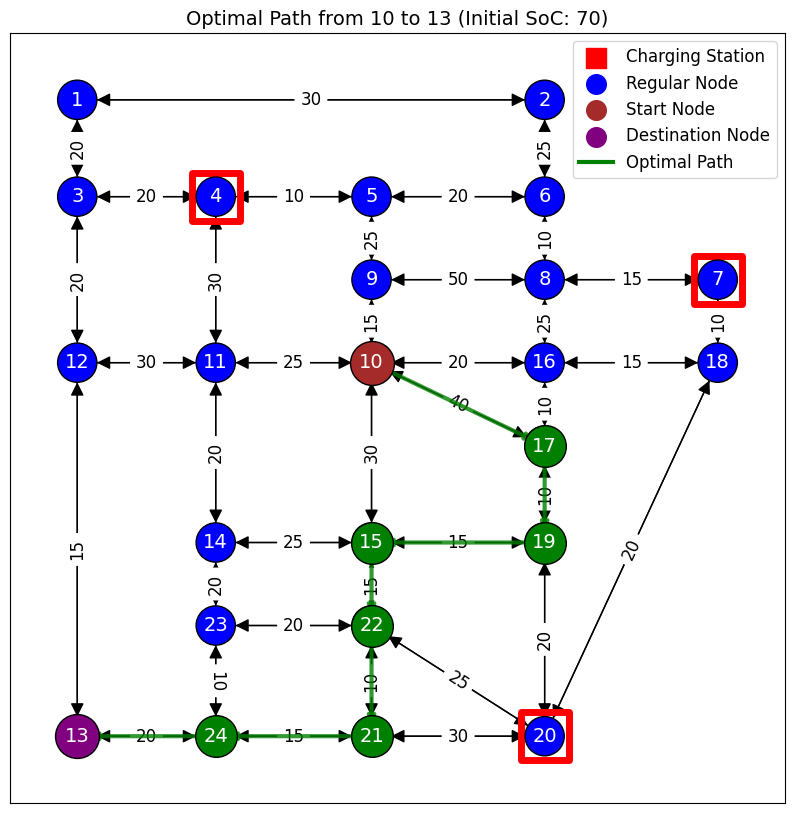

Saved plot to /content/drive/MyDrive/FYP_2025/DQN/plot_DQN/path_10_to_13_SoC_70_LEARCH.png


In [11]:
path = [10, 17, 19, 15, 22, 21, 24, 13]
plot_path(G, pos, path, charging_stations,10,13,70)

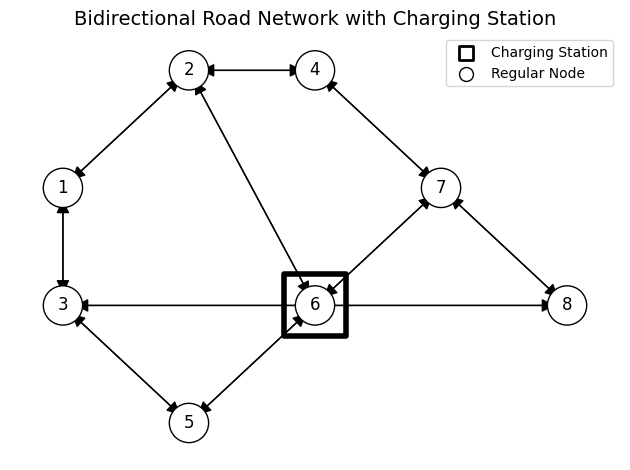

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a directed graph
G = nx.DiGraph()

# Define original edges (non-linear)
edges = [
    (1, 2), (2, 4), (1, 3), (3, 5), (5, 6), (2, 6),
    (4, 7), (6, 7), (7, 8), (3, 8)
]

# Add both directions for bidirectionality
bidirectional_edges = edges + [(v, u) for (u, v) in edges]
G.add_edges_from(bidirectional_edges)

# Define custom node positions
pos = {
    1: (0, 2), 2: (1, 3), 3: (0, 1), 4: (2, 3),
    5: (1, 0), 6: (2, 1), 7: (3, 2), 8: (4, 1)
}

# Define the charging station node
charging_station = 6

# Draw all nodes (blue)
node_colors = ['white' for n in G.nodes]
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=800, edgecolors="black")

# Highlight the charging station with a red square overlay
plt.scatter(pos[charging_station][0], pos[charging_station][1],
            s=2000, facecolors='none', edgecolors='black', linewidths=4, marker='s')

# Draw edges
nx.draw_networkx_edges(G, pos, edge_color='black', arrows=True, arrowsize=20)

# Draw node labels
nx.draw_networkx_labels(G, pos, font_color='black', font_size=12)

# Legend
plt.scatter([], [], marker='s', s=100, edgecolors='black', facecolors='none', linewidths=2, label='Charging Station')
plt.scatter([], [], color='white', s=100, edgecolors='black',label='Regular Node')
plt.legend(loc='upper right')

# Title and formatting
plt.title("Bidirectional Road Network with Charging Station", fontsize=14)
plt.axis('off')
plt.tight_layout()
plt.savefig("bidirectional_road_network_with_charging_station.png")
plt.show()


## GAP Method for evaluation

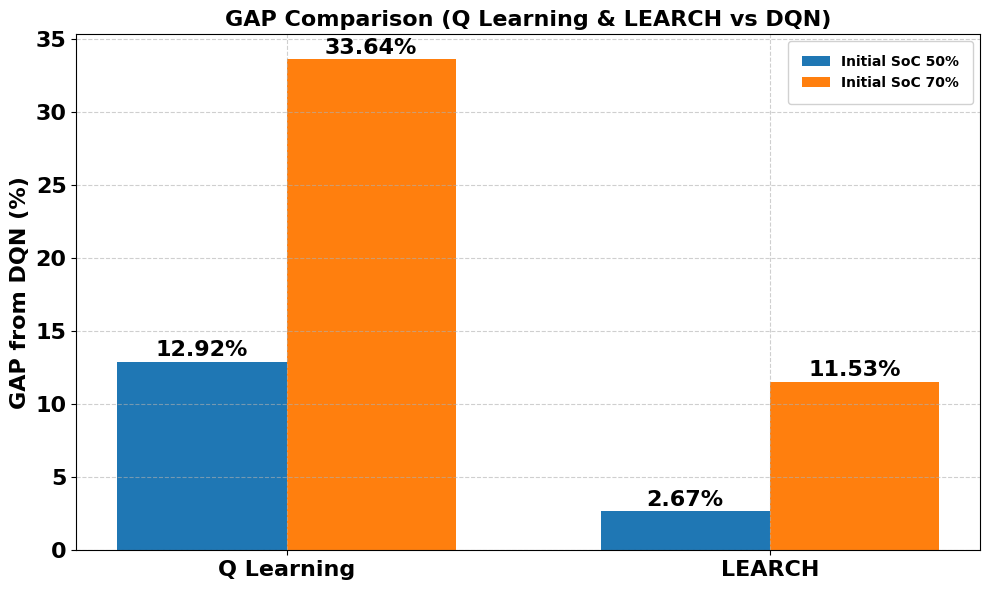

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Models to compare against DQN
models = ['Q Learning', 'LEARCH']

'''
TJourney
(min)
218.31
193.33
198.5
231.65

173.34
193.33

'''

# Total journey times
t_dqn_50 = 193.33
t_q_50 = 218.31
t_l_50 = 198.5

t_dqn_70 = 173.34
t_q_70 = 231.65
t_l_70 = 193.33

# Compute GAPs (relative to DQN)
gap_50 = [((t_q_50 - t_dqn_50) / t_dqn_50) * 100,
          ((t_l_50 - t_dqn_50) / t_dqn_50) * 100]

gap_70 = [((t_q_70 - t_dqn_70) / t_dqn_70) * 100,
          ((t_l_70 - t_dqn_70) / t_dqn_70) * 100]

x = np.arange(len(models))
width = 0.35

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width/2, gap_50, width, label='Initial SoC 50%')
bars2 = ax.bar(x + width/2, gap_70, width, label='Initial SoC 70%')

# Annotate bars
for bar in bars1 + bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}%',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 1),
                textcoords="offset points",
                ha='center', va='bottom',
                fontsize=16, fontweight='bold')

# Labels and aesthetics with bold fonts
ax.set_ylabel('GAP from DQN (%)', fontsize=16, fontweight='bold')
ax.set_title('GAP Comparison (Q Learning & LEARCH vs DQN)', fontsize=16, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(models, fontsize=16, fontweight='bold')
ax.legend(fontsize=16, frameon=True, loc='upper right', fancybox=True, framealpha=0.9, borderpad=1, prop={'weight': 'bold'})
ax.grid(True, linestyle='--', alpha=0.6)
ax.tick_params(axis='y', labelsize=16)
for label in ax.get_yticklabels():
    label.set_fontweight('bold')

plt.tight_layout()
pdf_path = "/content/GAP_Comparison_Q_Learning_LEARCH_vs_DQN.png"
plt.savefig(pdf_path)
plt.show()

plt.close()
